In [ ]:
pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 59.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 30.7 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.12.3
    Uninstalling tensorboard-2.12.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, MultiHeadAttention, LayerNormalization, Dropout, Dense
from tensorflow.keras.models import Sequential
print(tf.__version__)

2.13.0


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
D_MODEL = 512                      # Model dimension
NUM_HEADS = 8                      # Number of heads
D_K = int(D_MODEL / NUM_HEADS)     # Dimension of Q and K
D_V = D_K                          # Dimension of V
NUM_LAYERS = 3                     # Number of Encoder/Decoder Stacks
D_FF = 2048                        # Number of neurons in Feed Forward layer
MAX_TOKENS = 100                   # Maximum number of tokens in a sequence
DROPOUT_RATE = 0.1                 # Gloabl dropout rate
maxTokenLen = 25
epsilon = 0.0000001

# **1. Data**

In [ ]:
sheet_url = "https://docs.google.com/spreadsheets/d/1jipqsnc_L5Il90fX93yYtTlr_H7tNFB_Z5N2U2WsafM/edit#gid=0"
url_1 = sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')

df = pd.read_csv(url_1)
space = ' '
df = df.append({'Word':space}, ignore_index=True)
startToken = tf.convert_to_tensor([['<']])
words = list(df)
df_vocab = df[words].astype(str)
Vocab = df_vocab.to_numpy()

VOCAB_SIZE = np.shape(Vocab)[0]

<ipython-input-5-6b997c1ed99f>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Word':space}, ignore_index=True)


In [ ]:
def getVocabIdx(word):
  # Takes in str of word, return int of vocab index
  return df.index[df['Word'] == word].to_list()[0]

In [ ]:
token_length_to_index = {}
for idx, row in df.iterrows():
    if pd.notna(row['Word']):
        token_len = len(row['Word'])
        if token_len not in token_length_to_index:
            token_length_to_index[token_len] = []
        token_length_to_index[token_len].append((row['Word'], getVocabIdx(row['Word'])))

In [ ]:
def tokenize_and_pad_training(inputStrList):
  # Returns array of (samples, MAX_TOKENS+1) in order to get the right dimensions for Y
  global MAX_TOKENS
  # Initialize an empty list to store tokenized and padded sequences
  tokenized_sequences = []

  for inputStr in inputStrList:
      tokens = []
      charIdx = 0
      numChars = len(inputStr)

      while charIdx < numChars:
          found_token = False
          for windowSize in range(min(maxTokenLen, numChars - charIdx), 0, -1):
              token = inputStr[charIdx:charIdx + windowSize]
              if token_length_to_index.get(windowSize) is not None:
                  for word, vocab_idx in token_length_to_index[windowSize]:
                      if word == token:
                          tokens.append(vocab_idx)
                          charIdx += windowSize
                          found_token = True
                          break
              if found_token:
                  break
          if not found_token:
              charIdx += 1

      # Add start (1) and end (2) tokens before and after the sentence
      tokens = [1] + tokens + [2]

      # Pad or truncate the tokens to maxSeqLen
      tokens = tokens[:MAX_TOKENS] + [0] * (MAX_TOKENS+1 - len(tokens))

      tokenized_sequences.append(tokens)

  # Convert the list of tokenized sequences to a NumPy array
  output = np.array(tokenized_sequences)

  return output

In [ ]:
textX = ['What is the meaning of life?',
        'How does photosynthesis work?',
        'What is gravity?',
        'How many eggs are in a dozen?',
        'What is the capital of France?']
textY = ['The meaning of life is a philosophical question that has been debated for centuries.',
        'Photosynthesis is the process by which plants use sunlight, carbon dioxide, and water to produce glucose (sugar) and oxygen.',
        'Gravity is the force of attraction between two objects with mass.',
        'There are twelve eggs in a dozen.',
        'The capital of France is Paris.']

In [ ]:
tokensX = tokenize_and_pad_training(textX)[:, 0:MAX_TOKENS]
tokensY = tokenize_and_pad_training(textY)

In [ ]:
inputX = tokensX
inputY = tokensY[:,:-1]
trueY = tokensY[:,1:]

In [ ]:
inputX = inputX.astype(np.int32)
inputY = inputY.astype(np.int32)
inputY[inputY == 2] = 0
trueY = trueY.astype(np.int32)

In [ ]:
# testing
sample = 1

In [ ]:
inputX[sample,:]

array([    1,    10, 15908, 30086,   273, 30086,   540,  6950,  6074,
       30086,   210,    68,     2,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0], dtype=int32)

In [ ]:
inputY[sample,:]

array([    1,    18,   572,  1929,  6950,  6074, 30086,    93, 30086,
          86, 30086,   516, 30086,    96, 30086,   142, 30086,  2325,
       30086,   146, 30086, 13054,    65, 30086,  3829, 30086, 11202,
          65, 30086,    88, 30086,   419, 30086,    89, 30086,  2358,
       30086,  9767, 30086,    70,  3468,    71, 30086,    88, 30086,
        5643,    66,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0], dtype=int32)

In [ ]:
trueY[sample,:]

array([   18,   572,  1929,  6950,  6074, 30086,    93, 30086,    86,
       30086,   516, 30086,    96, 30086,   142, 30086,  2325, 30086,
         146, 30086, 13054,    65, 30086,  3829, 30086, 11202,    65,
       30086,    88, 30086,   419, 30086,    89, 30086,  2358, 30086,
        9767, 30086,    70,  3468,    71, 30086,    88, 30086,  5643,
          66,     2,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0], dtype=int32)

In [ ]:
NUM_SAMPLES = np.shape(inputX)[0]

numToTrain = int(np.round(0.8 * NUM_SAMPLES))

inputX_train = inputX[0:numToTrain, :]
inputX_val = inputX[numToTrain:NUM_SAMPLES+1, :]

inputY_train = inputY[0:numToTrain,:]
inputY_val = inputY[numToTrain:NUM_SAMPLES+1, :]

trueY_train = trueY[0:numToTrain,:]
trueY_val = trueY[numToTrain:NUM_SAMPLES+1, :]

BATCH_SIZE = 1

# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_tensor_slices(((inputX_train, inputY_train), trueY_train))     # slices along the first axis of both sets
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)     # creates batches of slices, of size batch_size

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices(((inputX_val, inputY_val), trueY_val))
val_dataset = val_dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)

In [ ]:
train_dataset
val_dataset

<_BatchDataset element_spec=((TensorSpec(shape=(None, 100), dtype=tf.int32, name=None), TensorSpec(shape=(None, 100), dtype=tf.int32, name=None)), TensorSpec(shape=(None, 100), dtype=tf.int32, name=None))>

#**2. Testing the Functions**

In [ ]:
for (batch, ((x_batch_train, y_batch_train), true_y_batch_train)) in enumerate(train_dataset):
  break

In [ ]:
print(x_batch_train)
print(y_batch_train)
print(true_y_batch_train)

tf.Tensor(
[[    1    10 15908 30086   273 30086   540  6950  6074 30086   210    68
      2     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]], shape=(1, 100), dtype=int32)
tf.Tensor(
[[    1    18   572  1929  6950  6074 30086    93 30086    86 30086   516
  30086    96 30086   142 30086  2325 30086   146 30086 13054    65 30086
   3829 30086 11202    65 30086    88 30086   419 30086    89 30086  2358
  30086  9767 30086    70  3468    71 30086    88 30086  5643    66     0
      0     0     0     0     0 

2.1 Embeddings

In [ ]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)


class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)  # Add mask_zero=True here
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, inputs, mask=None):
    # The mask returned by this layer is the same as the one received (identity mask).
    return mask

  def call(self, x, mask=None):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positional_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

In [ ]:
# We only use one embedder since the input and output vocab are the same
# (use two embedders if it's a vision transformer, one language to another
# language, etc)
gen_embed = PositionalEmbedding(vocab_size=VOCAB_SIZE, d_model=D_MODEL)

x_emb = gen_embed(x_batch_train)
y_emb = gen_embed(y_batch_train)

print(f'x_emb shape: {x_emb.shape}')
print(f'y_emb shape: {y_emb.shape}')

x_emb shape: (1, 100, 512)
y_emb shape: (1, 100, 512)


2.2 Attention Types

In [ ]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

In [ ]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [ ]:
sample_ca = CrossAttention(num_heads=2, key_dim=512)

print(sample_ca(x_emb, y_emb).shape)

(1, 100, 512)


In [ ]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [ ]:
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

print(sample_gsa(x_emb).shape)

(1, 100, 512)


In [ ]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [ ]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)

print(sample_csa(y_emb).shape)

(1, 100, 512)


Feed Forward

In [ ]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x

In [ ]:
sample_ffn = FeedForward(512, 2048)

print(sample_ffn(y_emb).shape)

(1, 100, 512)


Encoder Layer

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [ ]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

print(sample_encoder_layer(x_emb).shape)

(1, 100, 512)


Encoder Block

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

In [ ]:
# Instantiate the encoder.
sample_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=VOCAB_SIZE)

sample_encoder_output = sample_encoder(x_batch_train, training=False)

# Print the shape.
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

(1, 100, 512)


Decoder Layer

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

In [ ]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output = sample_decoder_layer(
    x=y_emb, context=x_emb)

print(sample_decoder_layer_output.shape)  # `(batch_size, seq_len, d_model)`

(1, 100, 512)


Decoder Block

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

In [ ]:
# Instantiate the decoder.
sample_decoder = Decoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=VOCAB_SIZE)

output = sample_decoder(
    x = y_batch_train,
    context = x_emb)

# Print the shapes.
print(x_batch_train.shape)
print(x_emb.shape)
print(output.shape)

(1, 100)
(1, 100, 512)
(1, 100, 512)


In [ ]:
sample_decoder.last_attn_scores.shape  # (batch, heads, target_seq, input_seq)

TensorShape([1, 8, 100, 100])

Transformer

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

In [ ]:
transformer = Transformer(
    num_layers = NUM_LAYERS,
    d_model = D_MODEL,
    num_heads = NUM_HEADS,
    dff = D_FF,
    input_vocab_size = VOCAB_SIZE,
    target_vocab_size = VOCAB_SIZE,
    dropout_rate = DROPOUT_RATE)

In [ ]:
output = transformer((x_batch_train, y_batch_train))

print(y_batch_train.shape)
print(x_batch_train.shape)
print(output.shape)
print(true_y_batch_train.shape)

(1, 100)
(1, 100)
(1, 100, 30087)
(1, 100)


In [ ]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

(1, 8, 100, 100)


In [ ]:
transformer.summary()

Model: "transformer_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_2 (Encoder)         multiple                  46914048  
                                                                 
 decoder_2 (Decoder)         multiple                  72121344  
                                                                 
 dense_47 (Dense)            multiple                  15434631  
                                                                 
Total params: 134470023 (512.96 MB)
Trainable params: 134470023 (512.96 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Learning Rate

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

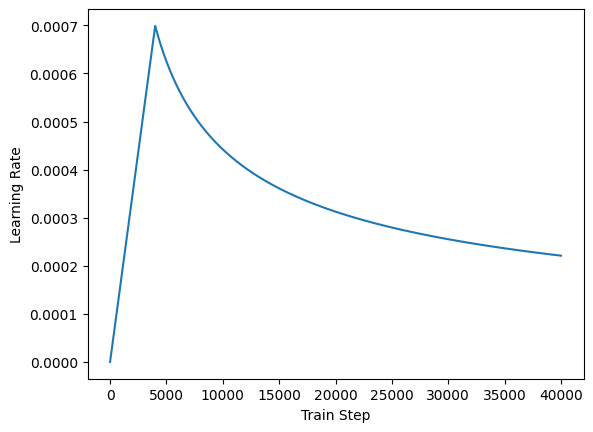

In [ ]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

Loss

In [ ]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

Compile

In [ ]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

Fit

In [ ]:
# Fit the model using NumPy arrays
transformer.fit(train_dataset,
    epochs=200,
    validation_data=val_dataset
)

Epoch 1/200
4/4 [==============================] - 29s 1s/step - loss: 10.2983 - masked_accuracy: 0.0000e+00 - val_loss: 10.2466 - val_masked_accuracy: 0.0000e+00
Epoch 2/200
4/4 [==============================] - 0s 48ms/step - loss: 10.2480 - masked_accuracy: 0.0000e+00 - val_loss: 10.2206 - val_masked_accuracy: 0.0000e+00
Epoch 3/200
4/4 [==============================] - 0s 46ms/step - loss: 10.2128 - masked_accuracy: 0.0000e+00 - val_loss: 10.1755 - val_masked_accuracy: 0.0000e+00
Epoch 4/200
4/4 [==============================] - 0s 45ms/step - loss: 10.1457 - masked_accuracy: 0.0083 - val_loss: 10.1135 - val_masked_accuracy: 0.0556
Epoch 5/200
4/4 [==============================] - 1s 303ms/step - loss: 10.0433 - masked_accuracy: 0.1159 - val_loss: 10.0345 - val_masked_accuracy: 0.2222
Epoch 6/200
4/4 [==============================] - 0s 49ms/step - loss: 9.9157 - masked_accuracy: 0.3408 - val_loss: 9.9413 - val_masked_accuracy: 0.2778
Epoch 7/200
4/4 [=========================

# **3. Testing**

In [ ]:
# Define a directory to save the model
model_dir = '/content/drive/MyDrive/Saved_Models'

In [ ]:
# Save the model
tf.saved_model.save(transformer, model_dir)

In [ ]:
# Load a saved model (optional)
loaded_model = tf.saved_model.load(model_dir)

NameError: ignored

In [ ]:
tokToShow = 2

x_in = np.reshape(inputX_train[0, :], (1, MAX_TOKENS))
y_in = np.reshape(inputY_train[0, 0:tokToShow], (1, tokToShow))

In [ ]:
output = transformer((x_in, y_in), training=False)[0, -1, :].numpy()
outputTok = np.argmax(output)
outputTok

ValueError: ignored

In [ ]:
class Responder(tf.Module):
  def __init__(self, transformer):
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    x_in = tokenize_and_pad_training([sentence])[:, 0:MAX_TOKENS]
    y_in = np.zeros((1, MAX_TOKENS)).astype(np.int32)
    startTok = Vocab[1]
    inputToks = [startTok]
    outputWords = []
    lastTok = 1
    tokToShow = 1
    while outputTok != 2 and tokToShow < MAX_TOKENS:
      y_in[0, tokToShow-1] = lastTok


In [ ]:
sentence = 'What is the meaning of life?'
x_in = tokenize_and_pad_training([sentence])[:, 0:MAX_TOKENS]
y_in = np.zeros((1, MAX_TOKENS)).astype(np.int32)
startTok = Vocab[1]
inputToks = [startTok]
outputWords = []
lastTok = 1
tokToShow = 1
while lastTok != 2 and tokToShow < MAX_TOKENS:
  y_in[0, tokToShow-1] = lastTok
  output = transformer((x_in, y_in), training=False)[0, -1, :].numpy()
  lastTok = np.argmax(output)
  outputWords.append(Vocab[lastTok, 0])
  tokToShow += 1
print("".join(outputWords))

NameError: ignored

Ignore

In [ ]:
sample = 0
nextTok = 0
outputToks = []
outputTok = 0

tokToShow = 1
while outputTok != 2 and tokToShow < MAX_TOKENS:
  x_in = np.reshape(inputX_train[sample, :], (1, MAX_TOKENS))
  y_in = np.reshape(inputY_train[sample, 0:tokToShow], (1, tokToShow))
  output = transformer((x_in, y_in), training=False)[0, -1, :].numpy()
  outputTok = np.argmax(output)
  outputToks.append(outputTok)
  tokToShow += 1



In [ ]:
trueToks = np.reshape(trueY[sample, :], (1, MAX_TOKENS-1))
print(f'True Tokens: {trueToks}')
predToks = np.reshape(np.array(outputToks), (1, len(outputToks)))
print(f'Predicted Tokens: {predToks}')

True Tokens: [[   22   138 30086  2849 30086    87 30086   285 30086    93 30086    29
  30086 10753 30086   677 30086    95 30086   125 30086   170 30086 20641
  30086    92 30086  8524    66     2     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0]]
Predicted Tokens: [[   22   138 30086  2849 30086    87 30086   285 30086    93 30086    29
  30086 10753 30086   677 30086    95 30086   125 30086   170 30086 20641
  30086    92 30086  8524    66     2]]


Saving

In [ ]:
from tensorflow.keras.models import load_model
transformer.save('/content/drive/MyDrive/Transformer_1.hdf5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


NotImplementedError: ignored

In [ ]:
class Speaker(tf.Module):
  def __init__(self, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    # The input sentence is Portuguese, hence adding the `[START]` and `[END]` tokens.
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()

    encoder_input = sentence

    # As the output language is English, initialize the output with the
    # English `[START]` token.
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # The output shape is `(1, tokens)`.
    text = tokenizers.en.detokenize(output)[0]  # Shape: `()`.

    tokens = tokenizers.en.lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights

In [ ]:
translator = Translator(transformer)

In [ ]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

# Other Functions

In [ ]:
for (batch, ((x_batch_train, y_batch_train), one_hot_y_batch_train)) in enumerate(train_dataset):
  break

In [ ]:
def speak(input):
  global MAX_TOKENS
  responses = []
  x_in = input
  y_in = np.array([[1]])
  nextToken = np.argmax(transformer([x_in, y_in], training=False).numpy())
  nextWord = Vocab[nextToken,0]
  responses.append(nextWord)
  numResponses = 1
  while nextWord != Vocab[2,:] and numResponses < MAX_TOKENS:
    y_in = np.concatenate((y_in, np.reshape(np.array(nextToken), (1,1))), axis=1)
    nextToken = np.argmax(transformer([x_in, y_in], training=False).numpy())
    nextWord = Vocab[nextToken,0]
    responses.append(nextWord)
    numResponses += 1
  print("".join(responses))

In [ ]:
question = np.reshape(tempX[0], (1, MAX_TOKENS))
print(speak(question))

In [ ]:
x_in = np.reshape(tempX[0], (1, MAX_TOKENS))
y_in = np.array([[4]])
response = transformer([x_in, y_in], training=False)
response_np = response.numpy()
idx = np.argmax(response_np)
print(idx)

# **Extra Stuff - Reserve**